Name of Members: 

- __LATOSA, JOSE ROMULO NORIEGA__
- __RAMIREZ, BENMAR SIM GREFALDA__
- __VICTORIA, ALFRED EUGENE TAGLE__

## I. Introduction

League of Legends (LOL), is a MOBA (Multiplayer Online Battle Arena) that's been around since 2009 is one of the most played games globally. 

The dataset we chose for this machine project, is the LOL Worlds 2021 Play-In Group Stats.

For the project we will go through the process of selecting and defining our chosen dataset, performing Exploratory Data Analysis (EDA), data preprocessing and cleaning, model training, HP tuning, model selection and insight extraction.

Our goal is to use the data from the LOL World's 2021 matches to predict the win/loss ratio of the teams and what role is the most important in terms of winning, based on the feature-engineered role performance metrics of the players.

We'll be utilizing machine learning and other techniques discussed in class to build up our predictive model.

## II. Description

The dataset has 220 instances (rows) and 20 features (columns). Each of the features are statistics of either the player or their team, aligned with their specific roles. As well as the gold earned, objectices taken and other important variables.

The data is the game stats for all matches in the League of Legends Worlds 2021 Play-in Groups.

The dataset stated it's collection process was done through lolesports.com, a website which shows all in-depth statistics available for each match, which allowed us to find correlations between in-game statistics and wins.

### List of Variables

| **Variable Name** | **Description**|
|--------------------------------------|----------------|
|**Team** | Acronym Code of Team.|
|**Player** | Nametag of Player.|
|**Opponent** | Acronym code of opposing team in match.|
|**Position**| Position played by player in a match, 5 unique variables.|
|**Champion**| Champion played by a player in a match.|
|**Kills**| Number of kills by player in a match.|
|**Deaths**| Number of deaths by a player in a match.|
|**Assists**| Number of assists by player in match.|
|**Creep Score**| Number of minions and monsters killed by player in a match.|
|**Gold Earned**| Gold earned by player in a match.|
|**Champion Damage** | Percentage of total damage done by team to other champions done by player.|
|**Kill Participation** | Percentage of team kills that player was part of.|
|**Wards Placed** | Number of wards placed by player in match.|
|**Wards Destroyed** | Number of wards killed by player in match.|
|**Wards Interactions** | Sum of wards placed and wards killed by player in match.|
|**Dragons For** | Number of dragons team killed in match.|
|**Dragons Against** | Number of dragons opposing team killed in match.|
|**Barons For** | Number of Barons killed in match.|
|**Barons Against** | Number of Barons opposing team killed in match.|
|**Win or Lose** | Win or Lose (W/L).|

## III. Modules

For this machine project, we will utilize the following Python libraries:

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

## IV. Data Cleaning

We are about to undertake various preprocessing and data cleaning methods to improve the dataset's usability and suitability for our exploratory analysis and model training. 

This process ensures the dataset is ready for use by addressing missing values, duplicates, outliers, and other errors, thereby representing the data accurately.

In the code block below, we will we importing and reading the League of Legends 2021 World Play-in Matches csv file.

In [71]:
worlds = pd.read_csv("LOL2021WORLDS.csv")
worlds.head()

,Team,Player,Opponent,Position,Champion,Kills,Deaths,Assists,Creep Score,Gold Earned,Champion Damage Share,Kill Participation,Wards Placed,Wards Destroyed,Ward Interactions,Dragons For,Dragons Against,Barons For,Barons Against,Result
0,UOL,Boss,GS,Top,Camille,4,5,3,188,11107,0.17,0.78,8,8,16,0,4,0,1,L
1,GS,Crazy,UOL,Top,Gwen,3,1,9,217,12201,0.20,0.52,10,7,17,4,0,1,0,W
2,UOL,Ahahacik,GS,Jungle,Trundle,2,4,5,156,9048,0.15,0.78,8,14,22,0,4,0,1,L
3,GS,Mojito,UOL,Jungle,Talon,5,4,10,194,11234,0.23,0.65,12,8,20,4,0,1,0,W
4,UOL,Nomanz,GS,Mid,Leblanc,1,3,4,216,9245,0.29,0.56,6,9,15,0,4,0,1,L


**Checking for Missing Values**

The code identifies and displays the columns in our worlds DataFrame that have missing values. It first counts the total number of missing values in each column and lists the columns with any missing data. 

This step is crucial to ensure we address any gaps in the data before proceeding with further processing.

In [72]:
# Check each column for missing values
missing_values = worlds.isnull().sum()

columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


**Checking for Duplicates**

This code identifies and removes duplicates rows in the worlds DataFrame, it finds all the duplicate rows and seperates them and prints out the rows. Duplicates are removed from the original dataframe and will only keep the first occurence.

In [73]:
# Find the duplicates
duplicate_uuids = worlds.duplicated(keep=False)

# Create a DataFrame for duplicates
duplicates = worlds[duplicate_uuids]

# Display the rows with duplicates
print("Duplicate Entries:\n", duplicates)

# Removing the duplicates if detected in DataFrame
if not duplicates.empty:
    worlds = worlds.drop_duplicates(keep='first')
    print(f"Duplicates removed. Dataset has {worlds.shape[0]} rows.")
else:
    print("No duplicates found.")


Duplicate Entries:
 Empty DataFrame
Columns: [Team, Player, Opponent, Position, Champion, Kills, Deaths, Assists, Creep Score, Gold Earned, Champion Damage Share, Kill Participation, Wards Placed, Wards Destroyed, Ward Interactions, Dragons For, Dragons Against, Barons For, Barons Against, Result]
Index: []
No duplicates found.


**Other Cleaning Processes**

The first processes replaces infinite values with NaN, which would stand for undefined data. While the second and third process would drop any columns and rows with more than 50% of its values missing.

In [74]:
# Replacing any erroneous infinite values
worlds = worlds.replace([np.inf, -np.inf], np.nan)

# Dropping columns with more than 50% missing values
worlds = worlds.dropna(thresh=len(worlds)*0.5, axis=1)

# Dropping rows with more than 50% missing values 
worlds = worlds.dropna(thresh=worlds.shape[1]*0.5, axis=0)

**Data Type Verification**

Ensuring the values in our dataset are of the correct data types is essential for effective data analysis and model training. Fortunately, our current dataset has appropriate data types for all variables and their respective values.

The importance of correct data types lies in achieving the following:

- **Data Integrity**: Ensures the consistency and accuracy of data.
- **Accuracy**: Provides precise and reliable data for analysis.
- **Efficiency**: Facilitates optimal processing and analysis speeds.
- **Compatibility**: Enhances compatibility with various data processing tools and methods.
- **Reliability**: Guarantees dependable results in analysis and modeling.

With these aspects in place, we can confidently proceed with our data analysis and model training.

In [75]:
# Printing all of the present data types
print("All data types present:\n", worlds.dtypes)

All data types present:
 Team                      object
Player                    object
Opponent                  object
Position                  object
Champion                  object
Kills                      int64
Deaths                     int64
Assists                    int64
Creep Score                int64
Gold Earned                int64
Champion Damage Share    float64
Kill Participation       float64
Wards Placed               int64
Wards Destroyed            int64
Ward Interactions          int64
Dragons For                int64
Dragons Against            int64
Barons For                 int64
Barons Against             int64
Result                    object
dtype: object


### Outlier Detection and Treatment

Outliers can significantly impact statistical measures and model performance. In the context of our dataset, outliers might represent unusual game conditions, errors in data collection, or truly exceptional events. 

Some examples of truly exceptional events could be C9 Sneaky dropping 50 kills in a game (insane btw) but this is highly unlikely for every other game and is considered an extreme outlier. 

In this dataset, varying values like kills, deaths, gold earned, and objectives taken are all subject to the team's playstyle and ability.

**Our Approach**

We conducted winsorization on the dataset to ensure its robustness against potential future outliers, particularly as the dataset expands. By capping the data at specified percentiles, we mitigate the influence of these extreme values.

Additionally, we presented visualizations of the data before and after outlier treatment to identify any existing outliers.

First, let's establish which columns we're going to check for outliers.

In [76]:
# Columns to check for outliers 
outlier_columns = ['Kills', 'Deaths', 'Assists', 'Creep Score', 
                   'Gold Earned', 'Champion Damage Share', 'Kill Participation', 
                   'Wards Placed', 'Wards Destroyed', 'Ward Interactions', 
                   'Dragons For', 'Dragons Against', 'Barons For', 'Barons Against']

After that, let's just make a copy of the worlds DataFrame to showcase the data before outlier treatment.

In [77]:
# Create a copy of the data before winsorization
worlds_before_outliers = worlds.copy()

We can then start the winsorization process by creating a function that caps values at specific percentiles, since the game has a lot of possibilities, and we can't possibly assume any values of the features based on domain knowledge (because you never know what'll happen in a league game) we can use extreme percentiles in our winsorization for a more forgiving threshold. This'll allow us to handle uncertainty in our data and keep data distortion at a minimal. We'll use a lower percentile of 1 and an upper percentile of 99.

In [78]:
# Winsorizes data by capping values at specified percentiles 
def winsorize(data, lower_percentile=1, upper_percentile=99): 
    lower_bound = np.percentile(data, lower_percentile) 
    upper_bound = np.percentile(data, upper_percentile) 
    return np.clip(data, lower_bound, upper_bound)

Now we apply winsorization using *winsorize* to the specified columns.

In [79]:
# Apply winsorization to the specified columns 
for column in outlier_columns: 
    worlds[column] = winsorize(worlds[column], lower_percentile=1, upper_percentile=99)

Next, is to truncate data the exceeds the upper bounds of our limits.

In [80]:
# Truncates data by removing values exceeding the upper bound
def truncate(data, upper_bound):
    return data[data <= upper_bound]

Let's visualize the distributions before and after winsorization, we'll use a few key features like, `Kills`, `Deaths`, `Assists`, and `Gold Earned`.

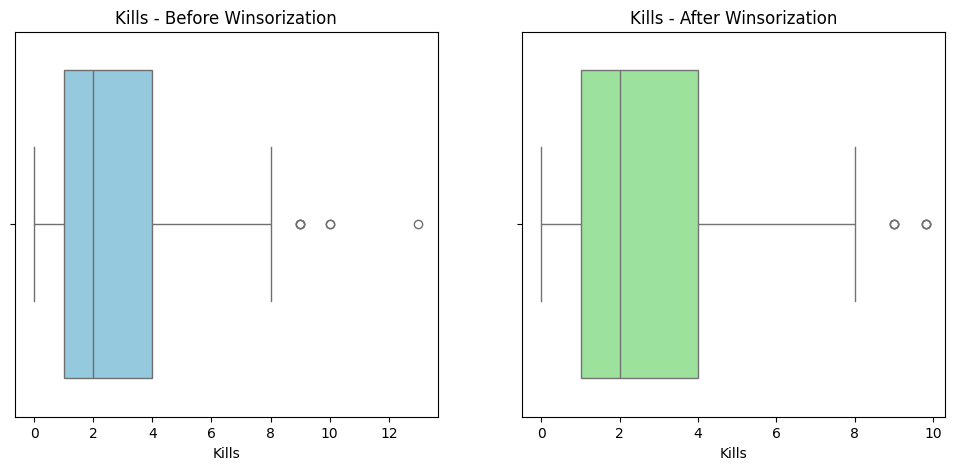

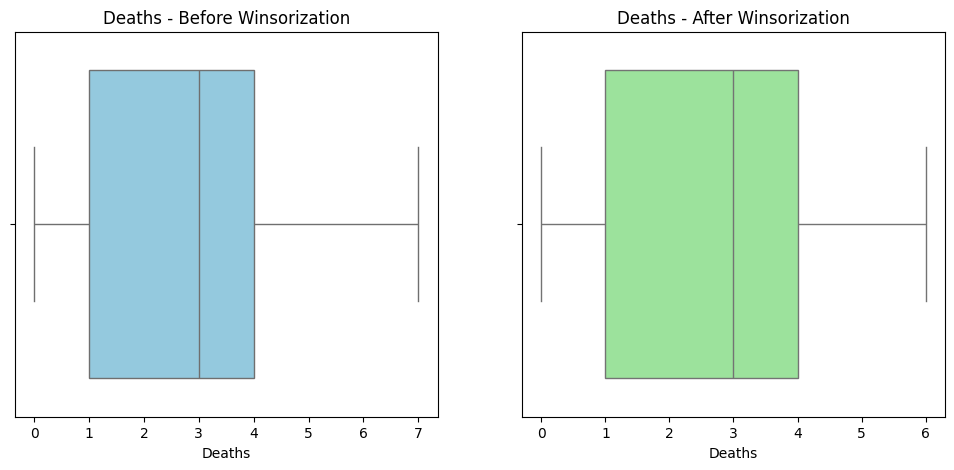

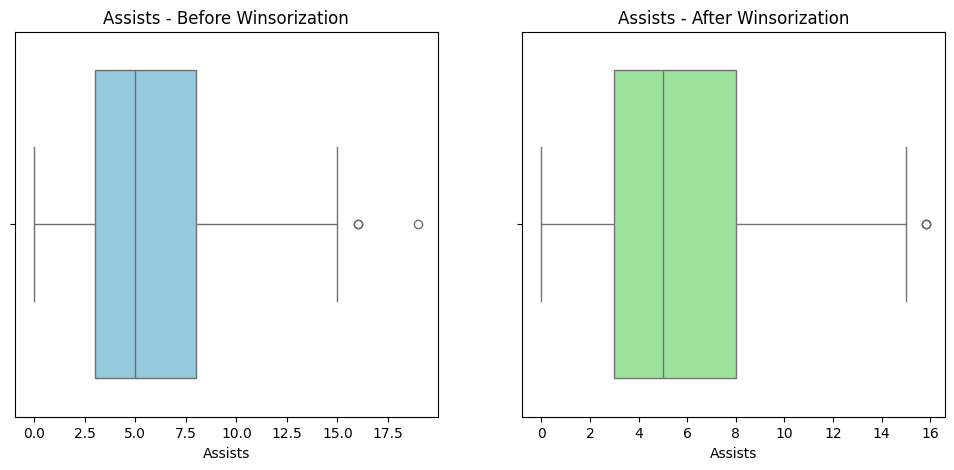

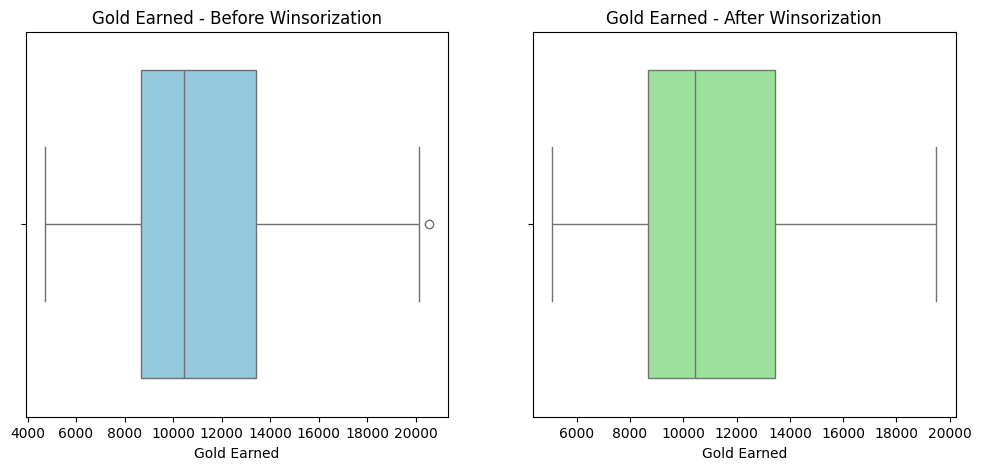

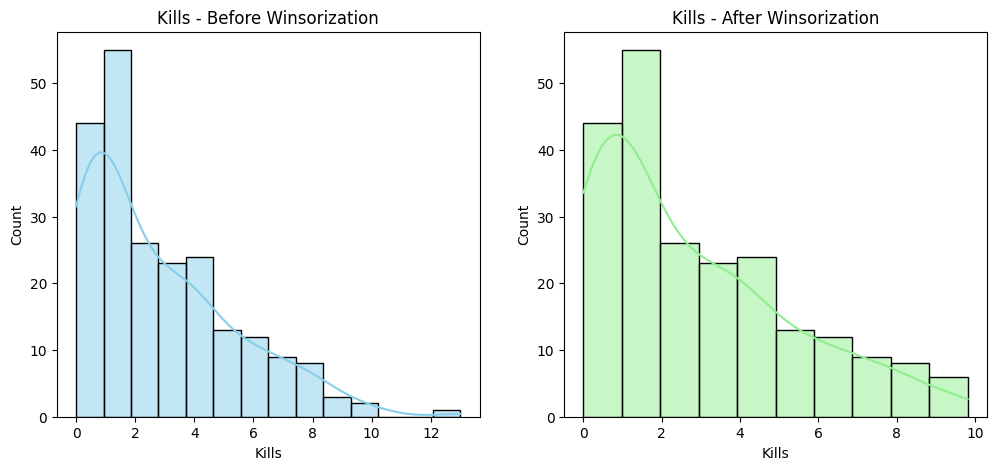

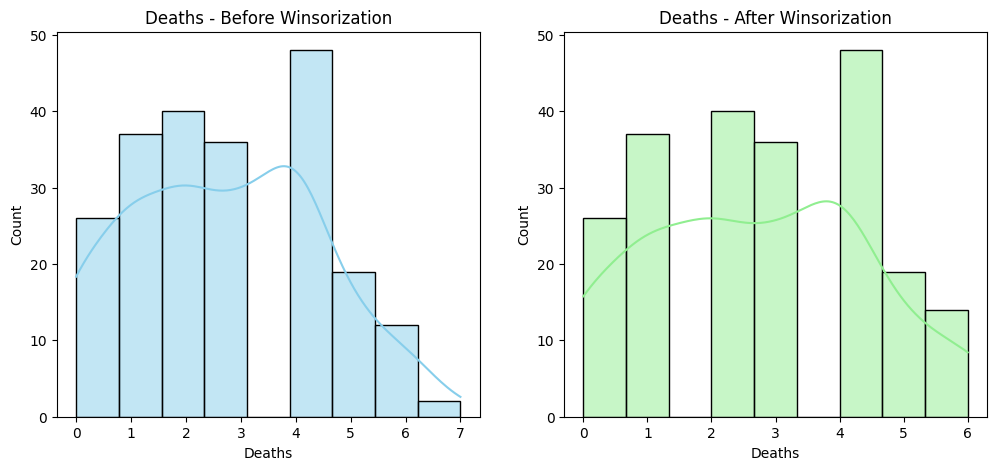

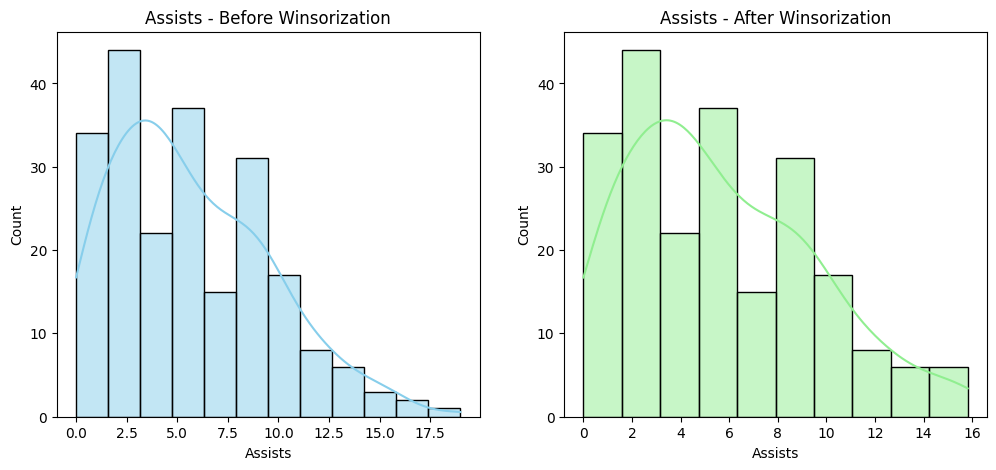

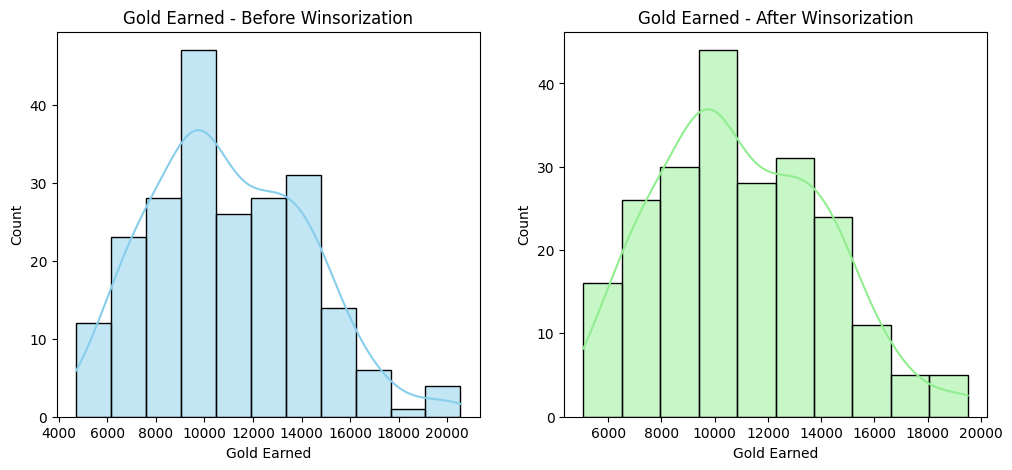

In [81]:
# List of features to visualize
features_to_visualize = ['Kills', 'Deaths', 'Assists', 'Gold Earned']

# Visualize before and after winsorization
for feature in features_to_visualize:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Before Winsorization
    sns.boxplot(data=worlds_before_outliers, x=feature, ax=axes[0], color='skyblue')
    axes[0].set_title(f'{feature} - Before Winsorization')
    
    # After Winsorization
    sns.boxplot(data=worlds, x=feature, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'{feature} - After Winsorization')
    
    plt.show()

for feature in features_to_visualize:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Before Winsorization
    sns.histplot(data=worlds_before_outliers, x=feature, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'{feature} - Before Winsorization')
    
    # After Winsorization
    sns.histplot(data=worlds, x=feature, kde=True, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'{feature} - After Winsorization')
    
    plt.show()

Now that we've done outlier treatment, it's time to divide the rows by their games. 10 rows in the dataset is equivalent to 1 game, with 10 players and 2 teams. Dividing them will allow us to measure stats per game.

In [82]:
# Reset index to ensure it's sequential 
worlds.reset_index(drop=True, inplace=True)
# Assign GameID 
worlds['GameID'] = (worlds.index // 10) + 1
# Group by GameID and collect the unique teams involved in each game 
game_teams = worlds.groupby('GameID')['Team'].unique().reset_index()

Let's make a function to extract the two teams, so per GameID, we can see what team is fight which.

In [83]:
# Function to extract the two teams 
def extract_teams(team_list): 
    unique_teams = list(team_list) 
    if len(unique_teams) == 2: 
        return pd.Series({'Team1': unique_teams[0], 'Team2': unique_teams[1]}) 
    else: 
    # Handle cases where there are not exactly two teams 
        return pd.Series({'Team1': unique_teams[0], 'Team2': unique_teams[0]})

Now we can apply this into the 'Team' column and drop it to merge game_teams back into the original DataFrame.

In [84]:
# Apply the function to the 'Team' column 
game_teams[['Team1', 'Team2']] = game_teams['Team'].apply(extract_teams) 
# Drop the original 'Team' column as it's no longer needed 
game_teams.drop('Team', axis=1, inplace=True) 
# Merge the game_teams back into the original 'worlds' DataFrame 
worlds = worlds.merge(game_teams, on='GameID', how='left')

Let's observe the sample.

In [85]:
# Display the first 20 rows to verify 
print(worlds[['GameID', 'Team1', 'Team2']].head(20))

    GameID Team1 Team2
0        1   UOL    GS
1        1   UOL    GS
2        1   UOL    GS
3        1   UOL    GS
4        1   UOL    GS
5        1   UOL    GS
6        1   UOL    GS
7        1   UOL    GS
8        1   UOL    GS
9        1   UOL    GS
10       2   DFM    C9
11       2   DFM    C9
12       2   DFM    C9
13       2   DFM    C9
14       2   DFM    C9
15       2   DFM    C9
16       2   DFM    C9
17       2   DFM    C9
18       2   DFM    C9
19       2   DFM    C9


### Data Transformation and Feature Engineering

We aim to calculate the `winrate` of teams based on both individual and team metrics.

**Individual Metrics**

`Kills, Deaths, Assists (KDA)`: This is the ratio of kills/deaths/assists of the players, helps us measure the stats of the player.

`Kill Participation Difference (KPD)`: This is the calculation of the difference between a player's KP and the average KP for their role, which provides insight into their performance.

`Damage Share Difference (DSD)`: This is the calculation of the difference between a player's Damage Share and the average DS for their role. This will show how much of an impact a player has in terms of dealing damage in comparison to their teammates.

We'll be using this with the Creep Score and Gold Earned.

**Team-based Metrics**

`Team Objectives`: This will be the total count of epic monsters like Elemental Dragons or Baron Nashors taken by the team in a specific game. Both of these objectives can't be soloed (unless under very specific conditions at any point of the game, especially in the meta LOL 2021 was under). This is an emphasis of team play and will be essential in measuring team-play performance. We will be using Barons For and Dragons For.

`Team Vision Score`: This is a measure of vision play in a specific game, it will be using the variables, Wards Placed, Wards Destroyed, and Ward Interactions.

`Team Variability`: This is a measure of how evenly or unevenly the damage output is distributed between team members, this can help us understand whether the team's playstyle focuses on more on specific members (like the damage dealers, Bottom and Middle doing most of the work) or if they do a well-rounded utility comp that does well in teamfights.

These features will be used with Team Total Assists.

We can then calculate KDA by getting the Kills + Assists over Deaths, in the event of a zero (0) death game, it will be replaced with 1.

In [86]:
# Calculate KDA
worlds['KDA'] = (worlds['Kills'] + worlds['Assists']) / worlds['Deaths'].replace(0, 1)

We calculate the Role Averages here to get an idea of standard performance of players. If a player has a KP or DS lower than the standard it just means they are underperforming, and if it's above average they are succeeding.

In [87]:
# Calculate Role Averages
individual_metrics = ['Creep Score', 'KDA', 'Gold Earned', 'Kill Participation', 'Champion Damage Share']
role_averages = worlds.groupby('Position')[individual_metrics].mean().reset_index()

# Rename columns for merging
role_averages.rename(columns={
    'Creep Score': 'Avg CS',
    'KDA': 'Avg KDA',
    'Gold Earned': 'Avg Gold Earned',
    'Kill Participation': 'Avg KP',
    'Champion Damage Share': 'Avg Damage Share'
}, inplace=True)

# Merge role averages into worlds
worlds = pd.merge(worlds, role_averages, on='Position', how='left')

# Print Role Averages
print("Role Averages:")
print(role_averages)

Role Averages:
  Position      Avg CS   Avg KDA  Avg Gold Earned    Avg KP  Avg Damage Share
0      Adc  279.160227  6.009811     13018.404545  0.631591          0.268409
1   Jungle  182.727273  4.160606     10490.818182  0.617727          0.177500
2      Mid  259.546591  4.559470     12024.590909  0.566016          0.236136
3  Support   41.490227  4.653750      7233.059545  0.659318          0.072727
4      Top  238.023864  4.606345     12248.977273  0.568395          0.243636


We are also going to calculate in this code block, the KPD and DSD. For KPD, it'll be Kill Participation - Average KP. For the DSD it'll be the same process but it'll use Champion Damage Share - Avg Damage Share.

In [88]:
# Calculate KPD
worlds['KP Difference'] = worlds['Kill Participation'] - worlds['Avg KP'] 

# Calculate DSD
worlds['Damage Share Difference'] = worlds['Champion Damage Share'] - worlds['Avg Damage Share']

Now, we can calculate the team metrics, wherein the first is where we calculate the team_objectives, the second for team_vision and the last one is just a simple computation to calculate the total team assists.

In [89]:
# Calculate Team Objectives Taken 
team_objectives = worlds.groupby(['GameID', 'Team']).agg({ 
    'Dragons For': 'max', 
    'Barons For': 'max' 
    }).reset_index() 
team_objectives['Objectives Taken'] = team_objectives['Dragons For'] + team_objectives['Barons For'] 
team_objectives = team_objectives[['GameID', 'Team', 'Objectives Taken']] 

# Calculate Team Vision Score 
team_vision = worlds.groupby(['GameID', 'Team']).agg({ 
    'Wards Placed': 'sum', 
    'Wards Destroyed': 'sum', 
    'Ward Interactions': 'sum' }).reset_index() 
team_vision['Vision Score'] = team_vision['Wards Placed'] + team_vision['Wards Destroyed'] + team_vision['Ward Interactions'] 
team_vision = team_vision[['GameID', 'Team', 'Vision Score']] 

# Calculate Team Total Assists 
team_assists = worlds.groupby(['GameID', 'Team'])['Assists'].sum().reset_index() 
team_assists.rename(columns={'Assists': 'Team Assists'}, inplace=True)

# Calculate Team Variability (Damage Share STD)
team_variability = worlds.groupby(['GameID', 'Team'])['Champion Damage Share'].std().reset_index()
team_variability.rename(columns={'Champion Damage Share': 'Damage Share STD'}, inplace=True)


Since we've calculated our newly engineered features, it's time to merge them into the worlds DataFrame.

In [90]:
# Merge team objectives into worlds
worlds = pd.merge(worlds, team_objectives, on=['GameID', 'Team'], how='left')
worlds = pd.merge(worlds, team_vision, on=['GameID', 'Team'], how='left')
worlds = pd.merge(worlds, team_assists, on=['GameID', 'Team'], how='left')
worlds = pd.merge(worlds, team_variability, on=['GameID', 'Team'], how='left')

# Display the DataFrame after merging team objectives
print("After merging Team Objectives:")
print(worlds[['GameID', 'Player', 'Team', 'Objectives Taken', "Vision Score", "Team Assists", "Damage Share STD"]].head(10))


After merging Team Objectives:
   GameID     Player Team  Objectives Taken  Vision Score  Team Assists  \
0       1       Boss  UOL                 0         224.0         19.00   
1       1      Crazy   GS                 5         234.0         52.81   
2       1   Ahahacik  UOL                 0         224.0         19.00   
3       1     Mojito   GS                 5         234.0         52.81   
4       1     Nomanz  UOL                 0         224.0         19.00   
5       1     Bolulu   GS                 5         234.0         52.81   
6       1   Argonavt  UOL                 0         224.0         19.00   
7       1      Alive   GS                 5         234.0         52.81   
8       1     Santas  UOL                 0         224.0         19.00   
9       1  Zergsting   GS                 5         234.0         52.81   

   Damage Share STD  
0          0.103441  
1          0.087750  
2          0.103441  
3          0.087750  
4          0.103441  
5          

Now that we have established all of our newly-engineered features, we can now use a MinMaxScaler to scale all of our metrics and features. Scaling the features ensures that all of them can contribute equally to our machine learning models.

A MinMaxScaler can scale our features to a range between 0 and 1.

In [91]:
# List of features to scale
features_to_scale = [
    'Creep Score', 'KDA', 'Gold Earned', 'KP Difference', 
    'Damage Share Difference', 'Objectives Taken', 
    'Vision Score', 'Team Assists', 'Damage Share STD'
]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
worlds[features_to_scale] = scaler.fit_transform(worlds[features_to_scale])

# Display the first few rows of the scaled features
print(worlds[features_to_scale].head())

   Creep Score       KDA  Gold Earned  KP Difference  Damage Share Difference  \
0     0.447380  0.077778     0.418204       0.772544                 0.195742   
1     0.525157  0.666667     0.494034       0.506608                 0.286401   
2     0.361557  0.097222     0.275486       0.722085                 0.335165   
3     0.463472  0.208333     0.427007       0.589118                 0.576923   
4     0.522475  0.092593     0.289141       0.549955                 0.581044   

   Objectives Taken  Vision Score  Team Assists  Damage Share STD  
0          0.000000      0.236861      0.297343          0.492361  
1          0.833333      0.273408      0.925664          0.316212  
2          0.000000      0.236861      0.297343          0.492361  
3          0.833333      0.273408      0.925664          0.316212  
4          0.000000      0.236861      0.297343          0.492361  


As we've already finished outlier treatment and feature engineering, it's time to decide which features we should drop. It's important to identify any features we have that won't contribute significantly to our models.

In [92]:
# Calculate the correlation matrix
corr_matrix = worlds[features_to_scale].corr().abs()

# Find highly correlated features (correlation > 0.9)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with correlation greater than 0.9
high_corr_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if upper_triangle.loc[row, column] > 0.9]

print("Highly correlated feature pairs (correlation > 0.9):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: correlation = {corr_matrix.loc[pair[1], pair[0]]:.2f}")


Highly correlated feature pairs (correlation > 0.9):


We calculated the correlation matrix to use the worlds DataFrame to check if there are any features with high correlation. Strong correlations suggest redundancy in those features. 

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a critical step in any data analysis or machine learning project. It enables us to understand the data's characteristics, identify patterns and relationships, detect anomalies, inform feature engineering, and validate our assumptions. For instance, performing EDA on the 'worlds' dataset will provide insights into the individual and team performance metrics that influence the teams' win rates. It will also shed light on team dynamics based on damage share and role averages, helping us understand the criteria for underperforming and overperforming players. These insights will guide our choice of models and assist us in engineering features that enhance our model's predictive capabilities.

Role averages provide a benchmark for assessing individual player performances relative to their roles. They show the typical performance metrics for each position, helping identify overperforming and underperforming players.

### Numerical Data

In [93]:
# Display role averages 
print("Role Averages:") 
print (role_averages)

Role Averages:
  Position      Avg CS   Avg KDA  Avg Gold Earned    Avg KP  Avg Damage Share
0      Adc  279.160227  6.009811     13018.404545  0.631591          0.268409
1   Jungle  182.727273  4.160606     10490.818182  0.617727          0.177500
2      Mid  259.546591  4.559470     12024.590909  0.566016          0.236136
3  Support   41.490227  4.653750      7233.059545  0.659318          0.072727
4      Top  238.023864  4.606345     12248.977273  0.568395          0.243636


Key observations here are that ADCs have the highest average CS and Gold Earned, which is a direct reflection of their role as primary damage dealers who rely on farming. They also contribute to the team's damage output the most with strong kill participation rates as well.

The support position focuses on utility rather than farming and has the lowest creep score and gold earned. The jungle position has a somewhat moderate metric impacting the game through objectives.

In [ ]:
# Extract unique combinations of GameID, Team, and scaled Damage Share STD
team_variability_scaled = worlds[['GameID', 'Team', 'Damage Share STD']].drop_duplicates()

# Display the scaled Damage Share STD per team per game
print("\nScaled Damage Share STD per Team per Game:")
print(team_variability_scaled)

The Damage Share STD measures the variability in damage contributions within a team. Higher values indicate greater reliance on specific players, while lower values suggest a more balanced distribution.

In [ ]:
# Find the team with the highest scaled Damage Share STD
highest_variability = team_variability_scaled.loc[team_variability_scaled['Damage Share STD'].idxmax()]
print("\nTeam with Highest Scaled Damage Share STD:")
print(highest_variability)

# Find the team with the lowest scaled Damage Share STD
lowest_variability = team_variability_scaled.loc[team_variability_scaled['Damage Share STD'].idxmin()]
print("\nTeam with Lowest Scaled Damage Share STD:")
print(lowest_variability)


Team with Highest Scaled Damage Share STD:
GameID               18
Team                BYG
Damage Share STD    1.0
Name: 171, dtype: object

Team with Lowest Scaled Damage Share STD:
GameID               13
Team                RED
Damage Share STD    0.0
Name: 120, dtype: object


**High Damage Share STD**: Teams with high values rely heavily on specific players for damage, which can be effective but risky if those players are neutralized.

**Low Damage Share STD**: Teams with low values have a balanced approach, making them more resilient to opponents targeting specific players.

In [ ]:
# Extract the first game
first_game_id = worlds['GameID'].min()
first_game = worlds[worlds['GameID'] == first_game_id]

# Display the first game's engineered features
engineered_features = ['KDA', 'KP Difference', 'Damage Share Difference', 'Team Assists', 'Vision Score', 'Damage Share STD']
print(f"\nFeatures of the First Game (Game ID {first_game_id}):")
print(first_game[engineered_features])



Features of the First Game (Game ID 1):
        KDA  KP Difference  Damage Share Difference  Team Assists  \
0  0.077778       0.772544                 0.195742      0.297343   
1  0.666667       0.506608                 0.286401      0.925664   
2  0.097222       0.722085                 0.335165      0.297343   
3  0.208333       0.589118                 0.576923      0.925664   
4  0.092593       0.549955                 0.581044      0.297343   
5  1.000000       0.774977                 0.460165      0.925664   
6  0.044444       0.360143                 0.574176      0.297343   
7  0.388889       0.534024                 0.423077      0.925664   
8  0.046296       0.454522                 0.410027      0.297343   
9  0.439167       0.597719                 0.349588      0.925664   

   Vision Score  Damage Share STD  
0      0.236861          0.492361  
1      0.273408          0.316212  
2      0.236861          0.492361  
3      0.273408          0.316212  
4      0.236861    

### Histograms

These charts show the distribution of four variables: KDA (Kill/Death/Assist), KP Difference (Kill Participation Difference), Damage Share Difference, and Damage Share STD.

The histograms represent the frequency of values in specific ranges, while the overlaid trend lines depict their probability density functions (PDFs).

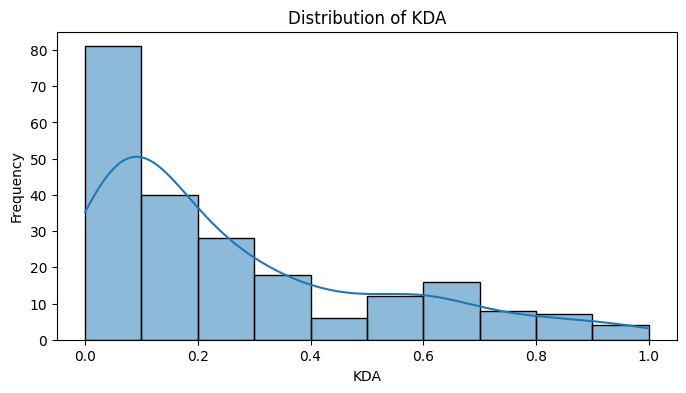

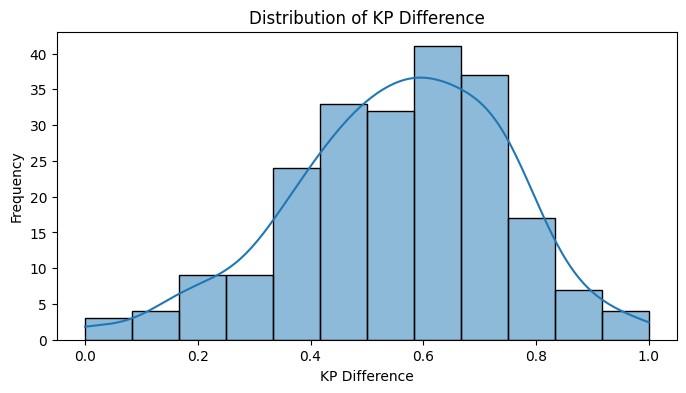

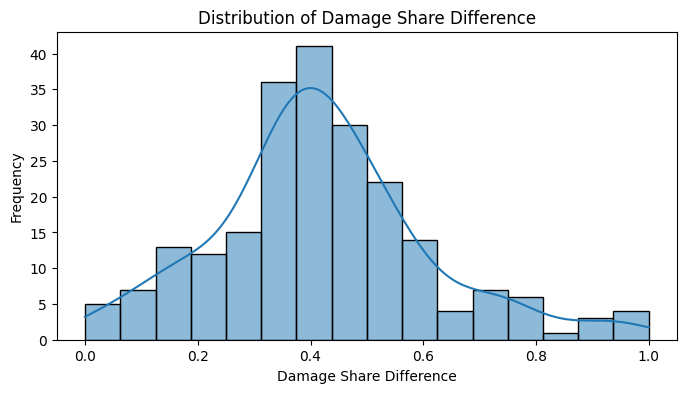

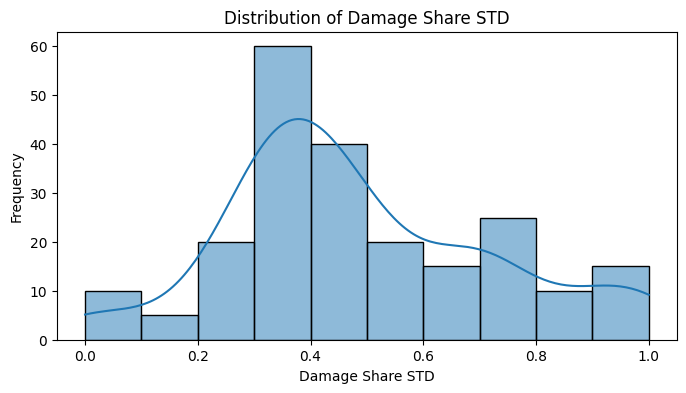

In [112]:
# Engineered features for histograms
engineered_features = ['KDA', 'KP Difference', 'Damage Share Difference', 'Damage Share STD']

# Plot histograms for each engineered feature
for feature in engineered_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(worlds[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In the KDA chart, the distribution is heavily right-skewed, with the majority of values concentrated around lower ranges, indicating most players have low KDA ratios. 

In contrast, the KP Difference, Damage Share Difference, and Damage Share STD distributions are more symmetrical, resembling a normal distribution centered around 0.5. This suggests a balanced spread of differences, with fewer extreme deviations. 


### Scatterplots

`X-axis (KP Difference)`: Represents the difference between a player's Kill Participation (KP) and the average KP for their role. Higher values indicate that the player is involved in more kills relative to their role average.

`Y-axis (Damage Share Difference)`: Represents the difference between a player's Champion Damage Share and the average Damage Share for their role. Higher values indicate that the player contributes more damage relative to their role average.

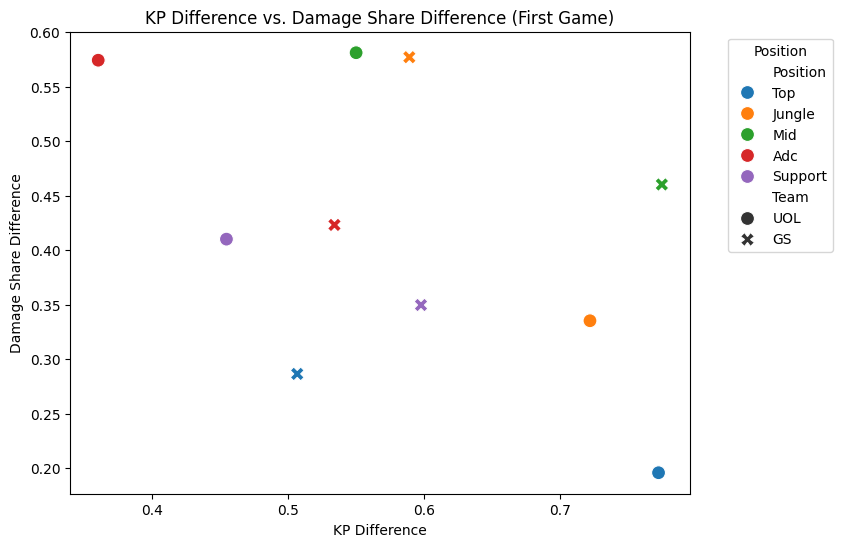

In [109]:
# Scatter plot of KP Difference vs. Damage Share Difference for the first game
plt.figure(figsize=(8, 6))
sns.scatterplot(x='KP Difference', y='Damage Share Difference',
                data=first_game, hue='Position', style='Team', s=100)
plt.title('KP Difference vs. Damage Share Difference (First Game)')
plt.xlabel('KP Difference')
plt.ylabel('Damage Share Difference')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

`Red Circle at the Top Left`: Indicates that the ADC from team UOL has a high Damage Share Difference but a lower KP Difference, suggesting this player deals a lot of damage compared to their role average but is less involved in kills.

`Blue Cross at the Bottom Right`: Indicates that the Top player from team GS has a high KP Difference but a lower Damage Share Difference, suggesting this player is highly involved in kills but contributes less damage relative to their role average.

## Model Training

Model training is a crucial step in the machine learning pipeline. It involves learning the underlying patterns in the training data so that we can make predictions on unseen data. The goal is to find a model that generalizes well, meaning it accurately predicts outcomes on new, unseen data based on the patterns it learned from the training data.

In this project, we trained several types of regression models on our 'worlds' dataset:

1. **Ridge Regression**: is a type of linear regression that includes a regularization term to prevent overfitting. The regularization term, also known as the L2 penalty, is added to the loss function, which helps constrain the model's coefficients.
2. **Regression Trees (Decision Trees)**: This is a type of model that breaks down our dataset into smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes, which provide a clear interpretation of why the model is making certain predictions. 
3. **Polynomial Regression**: This is a type of regression that models the relationship between the input variable (x) and the output variable (y) as an nth degree polynomial. Polynomial regression can model relationships between variables that aren't linear and can fit data with curves or slopes.

## Improving Model

Ridge Regression

Bagging

Polynomial Regression

## Model Selection

1. **Ridge Regression:**

2. **Bagging:** 

3. **Polynomial Regression:** 

## Insights and Conclusions

**Model Performance**:


**Data and Problem**:


**Overall**:


**Acknowledgements**:


## References

Lorem Ipsum